### Imports

In [76]:
import numpy as np

import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gsp

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable

from pathlib import Path
import os

import import_ipynb
from Analysis_functions import extract_data, means_calc, stream_crossing, easy_interpolate, \
     stream_alignment_step1, stream_alignment_step2, stream_shape, binned_relative_difference, \
     inertia_tensor, Iii, Iij, aspect_ratios

from Visualization_functions import snapshots_plot, anim_disc, anim_3d, anim_ComparetoTraceback

sys.path.insert(0, '/home/emelie/Desktop/Codes/PETAR/PeTar-master/tools/')
from analysis import *

In [2]:
plt.rcParams.update({'xtick.labelsize':20, 'ytick.labelsize':20, 'axes.titlesize':26, 
                     'axes.grid':True, 'axes.labelsize':24, 'legend.fontsize':20})

### Incomplete core evolution function

In [3]:
def core_evolution(rmin, rmax, n_shells, in_pos, in_mean_pos, data):
    """
    Parameters:
    -----------
    rmin: int or float
        The minimum considered radius of the core
    
    rmax: int or float
        The maximum considered radius of the core
        
    n_shells: int
        Number of core shells to use to calculate evolution as a function of radius
    
    in_pos: array
        Initial positions of particles in galaxy
        
    in_mean_pos: array
        Initial mean position of galaxy (found in PETAR header)
        
    data: array
        All data for all particles in all snapshots
    ------------------------------------------------------------------------------------
    """
    
    # Centering galaxy in coordinate system using header positions
    centered_data = in_pos - in_mean_pos
    
    # Calculating distance from the center to all particles in galaxy
    r_parts = np.sqrt(np.sum(centered_data**2, axis=1))
    
    # Array of all core radii
    core_radii = np.linspace(rmin, rmax, n_shells)
    
    # Mean core distances for all cores for all snapshots, shape:(n_snapshots, core_radii)
    mean_core_dists = np.empty((len(data[0, 0, :]), len(core_radii)))
    # Mean position of the core for all snapshots, shape:(n_snapshots, 3), 3 = x, y, z
    core_mean_pos = np.empty((len(data[0, 0, :]), 3))
    # shapes: (n_snapshots, n_cores)
    a_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    b_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    c_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    
    # Loops over different core radii, calculations for all snapshots are done in one go
    for i, core_rad in enumerate(core_radii):      
        # Which particles are inside certain radius of core
        core_part_rows = np.where(r_parts<=(core_rad))[0]

        # Extracting core particles' data for all timesteps
        core_parts_all_steps = data[core_part_rows, :, :]
        # Shape (n_core_part, 3, n_snapshots) ##(N, 3, 1) now (N, 3, 40)
        core_pos = core_parts_all_steps[:, 1:4, :] 
        
        
        #print(f'{np.shape(core_pos) = }')
        
        # Calculating mean distances between core particles for all timesteps
        # ----------------------------------------------------------------------------------------------
        pos_diffs = core_pos[:, np.newaxis, :, :] - core_pos[np.newaxis, :, :, :]
        #print(f'{np.shape(pos_diffs) = }')
        
        # Calculates the r-distance between all core particles
        # This gives a double-sided square array divided by the diagonal, which is 0
        # Shape: (n_core_part, n_core_part, n_snapshots)
        pos_dists = np.linalg.norm(pos_diffs, axis=2)
        #print(f'{np.shape(pos_dists) = }')
        
        # Shape: (n_snapshots)
        pos_mean_dists = np.mean(pos_dists[np.triu_indices(len(core_pos), k=1)], axis=0)
        #print(f'{np.shape(pos_mean_dists) = }')
        
        mean_core_dists[:, i] = pos_mean_dists#[:, np.newaxis]
        
        
        
        # Mean core position over time
        # ----------------------------------------------------------------------------------------
        if i==0:
            core_mean_pos[:, :] = np.mean(core_pos, axis=0).T # Should get shape (N_snapshots, 3)
        
        
        
        # Inertia tensor and aspect ratios
        # ---------------------------------------------------------------------------------------------
        #for j in range(len(data[0, 0, :])):
            #print(j)
            # Shape (n_core_part, 1)
            #core_masses = core_parts_all_steps[:, 0, j]
            #print(core_masses)
            #print(np.shape(core_masses))
            #print(np.shape(core_pos[:, :, j]))
            #row, col = np.shape(core_pos[:, :, j])
            #core_pos_tstep = core_pos[:, :, j] #np.reshape(core_pos[:, :, j], (row, col))
            #print(core_pos_tstep)
            #print(np.max(core_pos_tstep[:, 0]) - np.min(core_pos_tstep[:, 0]))
            #print(np.max(core_pos_tstep[:, 1]) - np.min(core_pos_tstep[:, 1]))
            #print(np.max(core_pos_tstep[:, 2]) - np.min(core_pos_tstep[:, 2]))
            #core_in_tensor = inertia_tensor(core_masses, core_pos_tstep)
            #print(core_in_tensor)
            #core_eig_vals, core_eig_vec = np.linalg.eig(core_in_tensor)
            
            
            #fig = plt.figure(figsize=(8, 8))
            #ax = fig.add_subplot(projection='3d')

            #ax.scatter(core_pos_tstep[:, 0], core_pos_tstep[:, 1], core_pos_tstep[:, 2], c='b', s=10)
            #lims = 10
            ##ax.set_xlim(-lims, lims)
            ##ax.set_ylim(-lims, lims)
            ##ax.set_zlim(-lims, lims)
            
            #ax.set_xlabel('x', labelpad=20)
            #ax.set_ylabel('y', labelpad=20)
            #ax.set_zlabel('z', labelpad=20)

            #ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.xaxis.get_major_formatter().set_powerlimits((0, 0))
            #ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.yaxis.get_major_formatter().set_powerlimits((0, 0))
            #ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.zaxis.get_major_formatter().set_powerlimits((0, 0))

            #plt.show()

            #eig1 = np.min(core_eig_vals)
            #eig3 = np.max(core_eig_vals)
            #eig2_pos = np.where((core_eig_vals!=np.min(core_eig_vals))&(core_eig_vals!=np.max(core_eig_vals)))[0]
            #eig2 = core_eig_vals[eig2_pos][0]
            #print(eig1, eig2, eig3)
            #print()

            #a_vals[j, i], b_vals[j, i], c_vals[j, i] = aspect_ratios(eig1, eig2, eig3, np.sum(core_masses))
            #print(a_vals[j, i])
            
    
    # Shape (n_snapshots, n_cores, 3)
    #core_aspect_ratios = np.concatenate([a_vals[:, :, np.newaxis], b_vals[:, :, np.newaxis], c_vals[:, :, np.newaxis]], axis=2)
    
    return core_mean_pos, mean_core_dists

# Fiducial model

## Trace back of Boo III Orbit, 3 particles, 1Gyr back in time

In [4]:
fid_trace_back_data, fid_trace_back_header, fid_trace_back_extra, fid_trace_back_hist_data = extract_data(r'btest2_data', r'Petar_back_test2', 125, 1)

print(fid_trace_back_data.shape)
print(fid_trace_back_extra.shape)
print(fid_trace_back_header.shape)

fid_trace_back_halfmass_r = fid_trace_back_extra[0, :]
#print(fid_trace_back_halfmass_r)

print(np.max(fid_trace_back_halfmass_r))
print(np.min(fid_trace_back_halfmass_r))

v_mean_fid_trace_back, r_mean_fid_trace_back = means_calc(fid_trace_back_header)

print(v_mean_fid_trace_back.shape)
print(r_mean_fid_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.014934474300677339
0.0006077755205047432
(126,)
(126,)


## Trace forward of Boo III Orbit, 3 particles, 7Gyr forward in time

In [5]:
fid_trace_forward_data, fid_trace_forward_header, fid_trace_forward_extra, fid_trace_forward_hist_data = extract_data(r'Trace_forward_fiducial_run_data', r'Trace_forward_fiducial_run', 2000, 1)

print(fid_trace_forward_data.shape)
print(fid_trace_forward_extra.shape)
print(fid_trace_forward_header.shape)

fid_trace_forward_halfmass_r = fid_trace_forward_extra[0, :]
#print(fid_trace_forward_halfmass_r)

print(np.max(fid_trace_forward_halfmass_r))
print(np.min(fid_trace_forward_halfmass_r))

v_mean_fid_trace_forward, r_mean_fid_trace_forward = means_calc(fid_trace_forward_header)

print(v_mean_fid_trace_forward.shape)
print(r_mean_fid_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
0.06259852657480973
0.0001785783876411207
(2001,)
(2001,)


## Fiducial model run, large: 997967particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $v_{r} = 197.5 \,$km$\,$s$^{-1}$
- $d = 46.5 \,$kpc
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [6]:
%%time
fid_mod_data, fid_mod_header, fid_mod_extra, fid_mod_hist_data = extract_data(r'fiducial_large_run_restart', 
                                                                                          r'Fiducial_large_run', 39, 1)

print(fid_mod_data.shape)
print(fid_mod_extra.shape)
print(fid_mod_header.shape)
print(fid_mod_header[:, -1])

fid_mod_halfmass_r = fid_mod_extra[0, :]
print(fid_mod_halfmass_r)

print(np.max(fid_mod_halfmass_r))
print(np.min(fid_mod_halfmass_r))

v_mean_fid_mod, r_mean_fid_mod = means_calc(fid_mod_header)

print(v_mean_fid_mod.shape)
print(r_mean_fid_mod.shape)

Number of particles is conserved: True
(997967, 21, 40)
(4, 40)
(8, 40)
[ 9.97967000e+05  4.99200000e+03  3.64234249e+01  1.54196121e+02
 -4.55313932e+01  6.32416793e+00  2.68520305e+01  1.52638686e+01]
[0.153      0.15276683 0.15336661 0.15311921 0.15286926 0.15284386
 0.15261422 0.15604073 0.16189008 0.16159944 0.1619651  0.16149155
 0.16171636 0.16166781 0.16194518 0.16181718 0.16147825 0.16168146
 0.16167951 0.16185507 0.16203091 0.16209706 0.16172908 0.16163228
 0.1619337  0.16194958 0.16202614 0.16203248 0.16178022 0.16065999
 0.17233712 0.17102987 0.1705406  0.17107929 0.17096251 0.17082212
 0.17165203 0.17136892 0.17183307 0.17223316]
0.17233712202666315
0.15261422246373507
(40,)
(40,)
CPU times: user 11min 19s, sys: 28.1 s, total: 11min 47s
Wall time: 11min 44s


###

### Pericentre and apocentre analysis

In [7]:
num_shells = 5
fid_core_mean_pos, fid_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=fid_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=fid_mod_header[2:5, 0], 
                                                       data=fid_mod_data)

In [8]:
fid_core_mean_r = np.sqrt(np.sum(fid_core_mean_pos**2, axis=1))

figt1, axt1 = plt.subplots(figsize=(8, 6))

tsteps = np.arange(0, 40, 1)*128

axt1.scatter(tsteps, fid_core_mean_r, s=10, c='b')

axt1.set_xlabel('Time [Myr]')
axt1.set_ylabel('Distance to GC [kpc]')

plt.show()

### Core calculations

In [43]:
fid_initial_inertia_tensor = inertia_tensor(fid_mod_data[:, 0, 0], fid_mod_data[:, 1:4, 0])

fid_initial_eig_vals, fid_initial_eig_vecs = np.linalg.eig(fid_initial_inertia_tensor)

eig_val1 = np.min(fid_initial_eig_vals)
eig_val3 = np.max(fid_initial_eig_vals)

eig2_pos = np.where((fid_initial_eig_vals!=eig_val1)&(fid_initial_eig_vals!=eig_val3))[0]
eig_val2 = fid_initial_eig_vals[eig2_pos][0]

print(eig_val1)
print(eig_val2)
print(eig_val3)

728810.2619515562
193400722333.3471
193400723445.0526


In [42]:
fid_initial_a, fid_initial_b, fid_initial_c = aspect_ratios(eig_val1, eig_val2, eig_val3, np.sum(fid_mod_data[:, 0, 0]))

print(f'a = {fid_initial_a:.5}')
print(f'b = {fid_initial_b:.5}')
print(f'c = {fid_initial_c:.5}')

a = 327.79
b = 0.45028
c = 0.4496


### Plotting snapshots

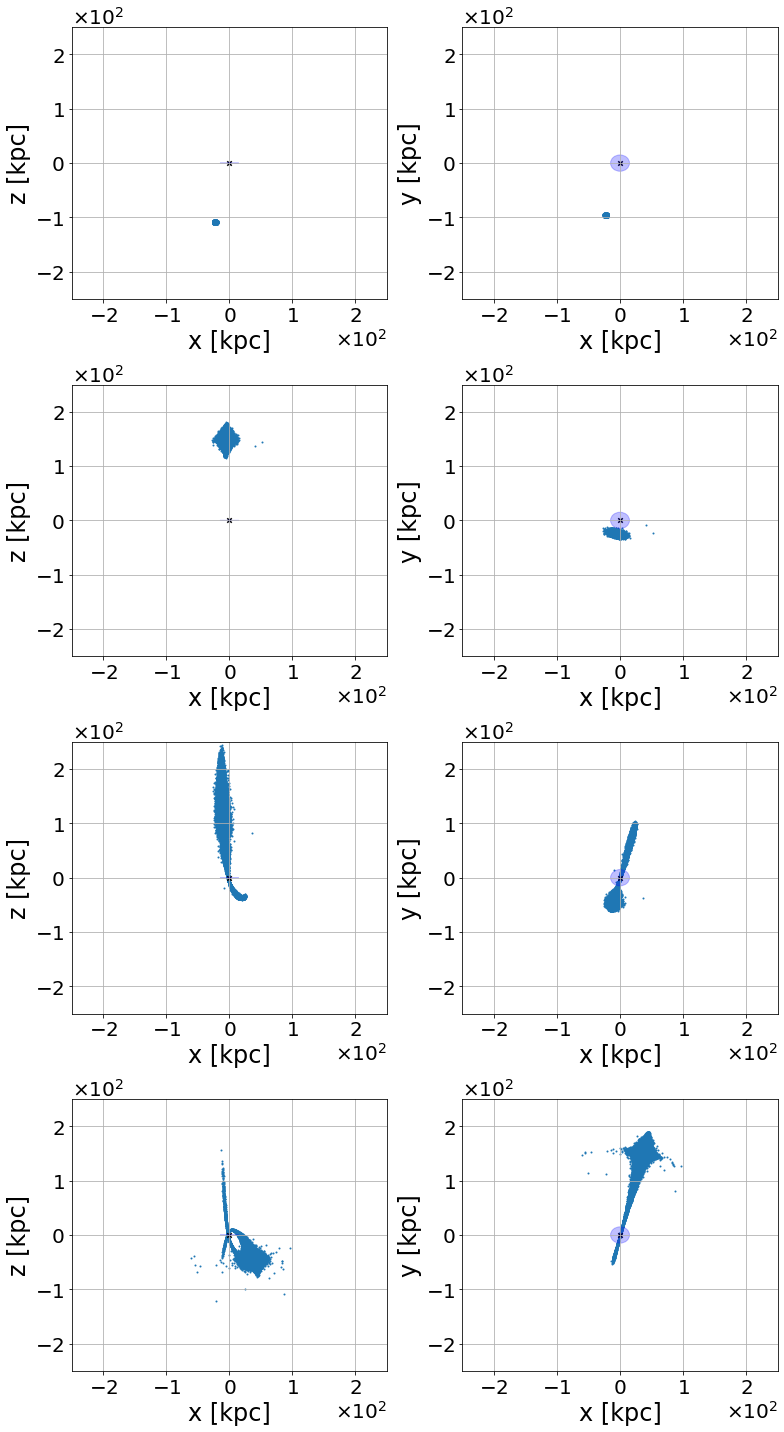

In [10]:
snapshots = [0, 14, 27, -1]
snapshots_plot(fid_mod_data, snapshots, 25.0e1, 25.0e1, (11, 20), 1, 'Fiducial_model', 
               save=False)

### Plotting trace forward orbit

tff = trace forward fiducial

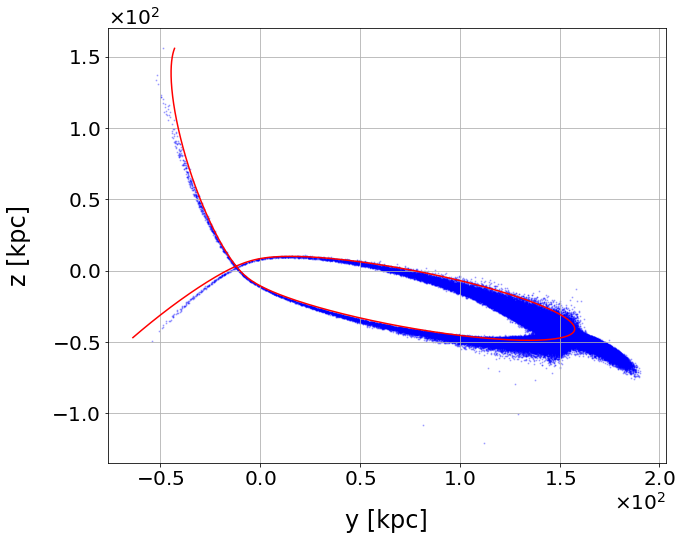

In [11]:
figtff, axtff = plt.subplots(figsize=(10, 8))
#axtff = figtff.add_subplot(projection='3d')

fid_low_tstep = 650
fid_high_tstep = 1735

axtff.plot(fid_trace_forward_data[0, 2, fid_low_tstep:fid_high_tstep], 
           fid_trace_forward_data[0, 3, fid_low_tstep:fid_high_tstep], color='r', 
           label='Trace forward')

axtff.scatter(fid_mod_data[:, 2, -1], fid_mod_data[:, 3, -1], c='b', s=1, alpha=0.25, label='Stream')


axtff.set_xlabel('y [kpc]', labelpad=20)
axtff.set_ylabel('z [kpc]', labelpad=20)
#axtff.set_zlabel('z [kpc]', labelpad=10)
axtff.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtff.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtff.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtff.zaxis.get_major_formatter().set_powerlimits((0, 0))


#axtff.view_init(45, 4)

plt.show()

### Constructing orbit data array for fiducial model

In [12]:
fid_orbit_position = fid_trace_forward_header[2:5, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)
fid_orbit_velocity = fid_trace_forward_header[5:8, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)
fid_orbit_times = fid_trace_forward_header[1, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
fid_orbit_data = np.concatenate([fid_orbit_position, fid_orbit_velocity, fid_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(fid_orbit_data)) # Expect shape n,7

(1085, 7)


### Interpolating orbit

In [13]:
interpolated_fid_orbit = easy_interpolate(fid_orbit_data, 2)
print(np.shape(interpolated_fid_orbit))
#print(interpolated_fid_orbit[:20, 3:6])

(4337, 8)


### Streatching out stream

In [14]:
# Has columns x, y, z, vx, vy, vz
fid_stream_data = fid_mod_data[:, 1:7, -1]
fid_orbital_data = np.delete(interpolated_fid_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

In [15]:
fid_aligned1 = stream_alignment_step1(fid_orbital_data, fid_stream_data)
print('St1 DONE')
fid_aligned2 = stream_alignment_step2(fid_orbital_data, fid_aligned1)
print('St2 DONE')

fid_length, fid_width, fid_part_dens = stream_shape(fid_orbital_data, fid_aligned2)
print('DONE')

Differences calculated
St1 DONE


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


St2 DONE
DONE


In [16]:
fid_variance = np.sum(fid_aligned1[:, -2])/len(fid_aligned1)

print(fid_variance)

1.6530862105323503


# Intermediate DM halo

## Trace back of Boo III Orbit, 3 particles, 1Gyr back in time

In [17]:
intm_dm_trace_back_data, intm_dm_trace_back_header, intm_dm_trace_back_extra, intm_dm_trace_back_hist_data = extract_data(r'Trace_back_heavy_DM_run_data', r'Trace_back_heavy_DM', 125, 1)

print(intm_dm_trace_back_data.shape)
print(intm_dm_trace_back_extra.shape)
print(intm_dm_trace_back_header.shape)

intm_dm_trace_back_halfmass_r = intm_dm_trace_back_extra[0, :]
#print(intm_dm_trace_back_halfmass_r)

print(np.max(intm_dm_trace_back_halfmass_r))
print(np.min(intm_dm_trace_back_halfmass_r))

v_mean_intm_dm_trace_back, r_mean_intm_dm_trace_back = means_calc(intm_dm_trace_back_header)

print(v_mean_intm_dm_trace_back.shape)
print(r_mean_intm_dm_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.09179376180686402
0.00023554979613951747
(126,)
(126,)


In [107]:
#anim_3d(intm_dm_trace_back_data, intm_dm_trace_back_header, tstep=8, nsteps=125, lims=15.0e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=10, run='Trace_back_intermediate_dm_run')

## Trace forward of Boo III Orbit, 3 particles, 8Gyr forward in time

In [18]:
intm_dm_trace_forward_data, intm_dm_trace_forward_header, intm_dm_trace_forward_extra, intm_dm_trace_forward_hist_data = extract_data(r'Trace_forward_heavy_DM_run_data', r'Trace_forward_heavy_DM', 2000, 1)

print(intm_dm_trace_forward_data.shape)
print(intm_dm_trace_forward_extra.shape)
print(intm_dm_trace_forward_header.shape)

intm_dm_trace_forward_halfmass_r = intm_dm_trace_forward_extra[0, :]
#print(intm_dm_trace_forward_halfmass_r)

print(np.max(intm_dm_trace_forward_halfmass_r))
print(np.min(intm_dm_trace_forward_halfmass_r))

v_mean_intm_dm_trace_forward, r_mean_intm_dm_trace_forward = means_calc(intm_dm_trace_forward_header)

print(v_mean_intm_dm_trace_forward.shape)
print(r_mean_intm_dm_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
0.001173027044743447
8.069108508041147e-05
(2001,)
(2001,)


In [8]:
#anim_3d(intm_dm_trace_forward_data, intm_dm_trace_forward_header, tstep=4, nsteps=2000, lims=17.5e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=25, run='Trace_forward_intermediate_dm_run')

## Intermediate DM mass model run, large: 999201 particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $M_{DM, PETAR} = 3930190616.3844$
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [19]:
%%time
intm_dm_mod_data, intm_dm_mod_header, intm_dm_mod_extra, intm_dm_mod_hist_data = extract_data(r'Heavy_DM_run_data', 
                                                                                          r'Heavy_DM_run', 39, 1)

print(intm_dm_mod_data.shape)
print(intm_dm_mod_extra.shape)
print(intm_dm_mod_header.shape)
print(intm_dm_mod_header[:, -1])

intm_dm_mod_halfmass_r = intm_dm_mod_extra[0, :]
print(intm_dm_mod_halfmass_r)

print(np.max(intm_dm_mod_halfmass_r))
print(np.min(intm_dm_mod_halfmass_r))

v_mean_intm_dm_mod, r_mean_intm_dm_mod = means_calc(intm_dm_mod_header)

print(v_mean_intm_dm_mod.shape)
print(r_mean_intm_dm_mod.shape)

Number of particles is conserved: True
(999201, 21, 40)
(4, 40)
(8, 40)
[ 9.99201000e+05  4.99200000e+03 -1.64680446e+00 -6.94913539e+00
  6.36496719e+00  5.58275181e+00  2.20413699e+01 -5.05448835e+02]
[0.153      0.15253245 0.15167442 0.15189494 0.15210847 0.15184544
 0.15178435 0.15067258 0.17160939 0.1680185  0.16812206 0.16791453
 0.16814739 0.16783699 0.16769703 0.16633263 0.1918258  0.18966144
 0.19076587 0.19040284 0.18961688 0.18984123 0.19029797 0.18890889
 0.22695822 0.22230136 0.2286091  0.22967984 0.22328987 0.22229235
 0.22235246 0.22746746 0.34407066 0.31185303 0.32663393 0.3375796
 0.31261992 0.30648047 0.30977433 0.32701372]
0.3440706640153367
0.15067258023163027
(40,)
(40,)
CPU times: user 11min 21s, sys: 25.4 s, total: 11min 46s
Wall time: 11min 46s


### Pericentre and apocentre analysis

In [20]:
num_shells = 5
intm_dm_core_mean_pos, intm_dm_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=intm_dm_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=intm_dm_mod_header[2:5, 0], 
                                                       data=intm_dm_mod_data)

In [21]:
intm_dm_core_mean_r = np.sqrt(np.sum(intm_dm_core_mean_pos**2, axis=1))

figt2, axt2 = plt.subplots(figsize=(8, 6))

tsteps = np.arange(0, 40, 1)*128

axt2.plot(tsteps, intm_dm_core_mean_r, color='b', marker='o')

axt2.set_xlabel('Time [Myr]')
axt2.set_ylabel('Distance to GC [kpc]')

plt.show()

###

### Plotting snapshots

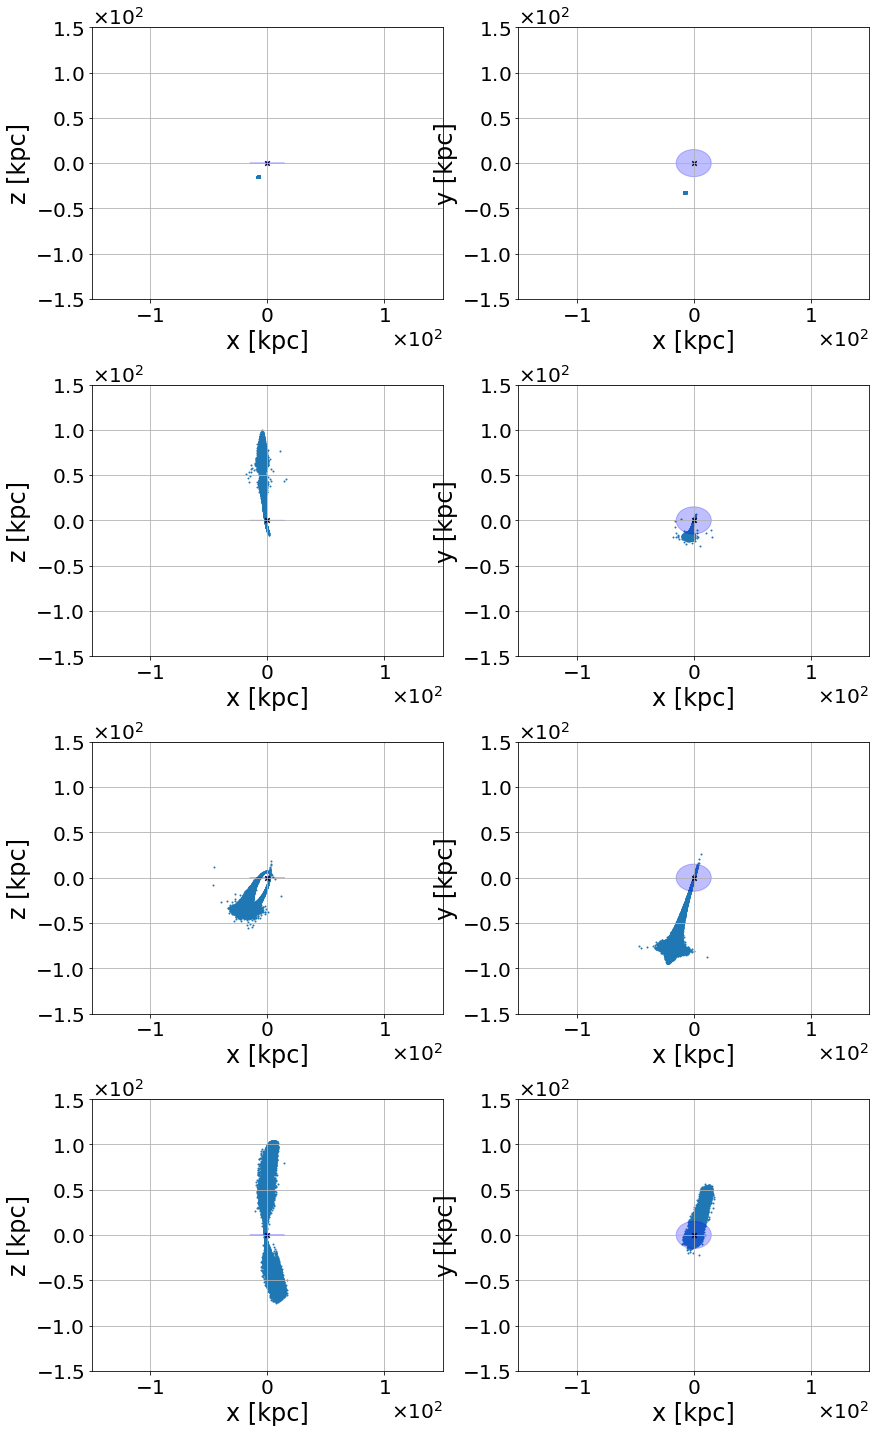

In [23]:
snapshots = [0, 14, 27, -1]
snapshots_plot(intm_dm_mod_data, snapshots, 15.0e1, 15.0e1, (12, 20), 1, 'Intermediate_DM_model', 
               save=False)

### Plotting trace forward orbit

tfh = trace forward heavy (dm)

In [24]:
i_min_pos = intm_dm_trace_forward_data[0, 1:4, 0]
i_max_pos = intm_dm_trace_forward_data[0, 1:4, -1]

i_diff = i_max_pos - i_min_pos
i_dist = np.sqrt(np.sum(i_diff**2))
print(i_dist)

57.51343098992289


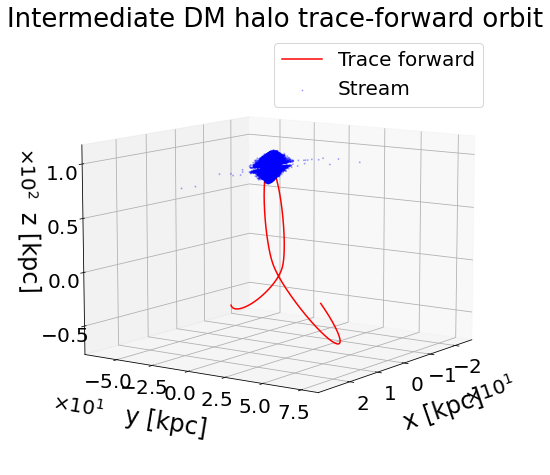

In [55]:
figtfi = plt.figure(figsize=(10, 8))
axtfi = figtfi.add_subplot(projection='3d', computed_zorder=False)

#u = np.linspace(0, 2 * np.pi, 100)
#v = np.linspace(0, np.pi, 100)

#x_bulge = 1.500 * np.outer(np.cos(u), np.sin(v))
#y_bulge = 1.500 * np.outer(np.sin(u), np.sin(v))
#z_bulge = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

#x_disc = 14.490 * np.outer(np.cos(u), np.sin(v))
#y_disc = 14.490 * np.outer(np.sin(u), np.sin(v))
#z_disc = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))


t = np.linspace(0, 2001, 2001)

intm_dm_low_tstep = 100
intm_dm_high_tstep = 700

axtfi.plot(intm_dm_trace_forward_data[0, 1, intm_dm_low_tstep:intm_dm_high_tstep],
            intm_dm_trace_forward_data[0, 2, intm_dm_low_tstep:intm_dm_high_tstep], 
           intm_dm_trace_forward_data[0, 3, intm_dm_low_tstep:intm_dm_high_tstep], 
           c='r', label='Trace forward')#, s=10, cmap='spring')

axtfi.scatter(intm_dm_mod_data[:, 1, 11], intm_dm_mod_data[:, 2, 11], intm_dm_mod_data[:, 3, 11], 
              s=1, alpha=0.25, c='b', label='Stream', zorder=20)

#plt.colorbar(sc)
axtfi.set_xlabel('x [kpc]', labelpad=20)
axtfi.set_ylabel('y [kpc]', labelpad=20)
axtfi.set_zlabel('z [kpc]', labelpad=10)
axtfi.set_title('Intermediate DM halo trace-forward orbit')
axtfi.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfi.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfi.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfi.yaxis.get_major_formatter().set_powerlimits((0, 0))
axtfi.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfi.zaxis.get_major_formatter().set_powerlimits((0, 0))

#axtfi.plot_surface(x_bulge, y_bulge, z_bulge, color='grey', alpha=0.5)
#axtfi.plot_surface(x_disc, y_disc, z_disc, color='grey', alpha=0.5)

axtfi.legend()


axtfi.view_init(10, 35)

plt.show()

### Constructing orbit data array for high $v_r$ model

intm_dm_orbit_position = intm_dm_trace_forward_header[2:5, intm_dm_low_tstep:intm_dm_high_tstep].T # To get shape (N,x)
intm_dm_orbit_velocity = intm_dm_trace_forward_header[5:8, intm_dm_low_tstep:intm_dm_high_tstep].T # To get shape (N,x)
intm_dm_orbit_times = intm_dm_trace_forward_header[1, intm_dm_low_tstep:intm_dm_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
intm_dm_orbit_data = np.concatenate([intm_dm_orbit_position, intm_dm_orbit_velocity, intm_dm_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(intm_dm_orbit_data)) # Expect shape n,7

### Interpolating orbit

interpolated_intm_dm_orbit = easy_interpolate(intm_dm_orbit_data, 2)
print(np.shape(interpolated_intm_dm_orbit))
#print(interpolated_intm_dm_orbit[:20, 3:6])

### Making animations

In [117]:
#%%time
#anim_3d(intm_dm_mod_data, intm_dm_mod_header, tstep=128, 
#        nsteps=39+1, lims=12.0e1, fsize=(10, 10), 
#        marker_size=1, tx=-0.3e2, ty=0.4e2, tz=0.4e2, 
#        format_type='mp4', fps=6, run='Intermediate_dm_model')

In [120]:
#anim_ComparetoTraceback(intm_dm_mod_data, intm_dm_trace_back_data, lims=0.5e2, 
#                        run_file='Intm_dm_run_and_trace_back', run_title='Intermediate DM run compared to trace back',
#                        fsize=(10, 10), fps=1, format_type='mp4')

### Streatching out stream

# Has columns x, y, z, vx, vy, vz
intm_dm_stream_data = intm_dm_mod_data[:, 1:7, -1]
intm_dm_orbital_data = np.delete(interpolated_intm_dm_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

intm_dm_aligned1 = stream_alignment_step1(intm_dm_orbital_data, intm_dm_stream_data)
print('St1 DONE')
intm_dm_aligned2 = stream_alignment_step2(intm_dm_orbital_data, intm_dm_aligned1)
print('St2 DONE')

intm_dm_length, intm_dm_width, intm_dm_part_dens = stream_shape(intm_dm_orbital_data, intm_dm_aligned2)
print('DONE')

intm_dm_variance = np.sum(intm_dm_aligned1[:, -2])/len(intm_dm_aligned1)

print(intm_dm_variance)

# Very heavy DM halo

In [56]:
heavy_dm_trace_back_data, heavy_dm_trace_back_header, heavy_dm_trace_back_extra, heavy_dm_trace_back_hist_data = extract_data(r'Trace_back_very_heavy_DM_run_data', r'Trace_back_very_heavy_DM', 125, 1)

print(heavy_dm_trace_back_data.shape)
print(heavy_dm_trace_back_extra.shape)
print(heavy_dm_trace_back_header.shape)

heavy_dm_trace_back_halfmass_r = heavy_dm_trace_back_extra[0, :]
#print(heavy_dm_trace_back_halfmass_r)

print(np.max(heavy_dm_trace_back_halfmass_r))
print(np.min(heavy_dm_trace_back_halfmass_r))

v_mean_heavy_dm_trace_back, r_mean_heavy_dm_trace_back = means_calc(heavy_dm_trace_back_header)

print(v_mean_heavy_dm_trace_back.shape)
print(r_mean_heavy_dm_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.1233513128374238
4.001548006481967e-05
(126,)
(126,)


In [14]:
#anim_3d(heavy_dm_trace_back_data, heavy_dm_trace_back_header, tstep=8, nsteps=125, lims=15.0e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=10, run='Trace_back_heavy_dm_run')#

## Trace forward of Boo III Orbit, 3 particles, 8Gyr forward in time

In [57]:
heavy_dm_trace_forward_data, heavy_dm_trace_forward_header, heavy_dm_trace_forward_extra, heavy_dm_trace_forward_hist_data = extract_data(r'Trace_forward_very_heavy_DM_run_data', r'Trace_forward_very_heavy_DM', 2000, 1)

print(heavy_dm_trace_forward_data.shape)
print(heavy_dm_trace_forward_extra.shape)
print(heavy_dm_trace_forward_header.shape)

heavy_dm_trace_forward_halfmass_r = heavy_dm_trace_forward_extra[0, :]
#print(heavy_dm_trace_forward_halfmass_r)

print(np.max(heavy_dm_trace_forward_halfmass_r))
print(np.min(heavy_dm_trace_forward_halfmass_r))

v_mean_heavy_dm_trace_forward, r_mean_heavy_dm_trace_forward = means_calc(heavy_dm_trace_forward_header)

print(v_mean_heavy_dm_trace_forward.shape)
print(r_mean_heavy_dm_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
4006.775393955891
0.00011820899824696788
(2001,)
(2001,)


In [15]:
#anim_3d(heavy_dm_trace_forward_data, heavy_dm_trace_forward_header, tstep=4, nsteps=2000, lims=17.5e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=20, run='Trace_forward_heavy_dm_run')

In [19]:
print(np.sum(heavy_dm_trace_forward_data[:, 0, 0]))
print(np.sum(intm_dm_trace_forward_data[:, 0, 0]))
print(np.sum(fid_trace_forward_data[:, 0, 0]))

print(np.sum(heavy_dm_trace_back_data[:, 0, 0]))
print(np.sum(intm_dm_trace_back_data[:, 0, 0]))
print(np.sum(fid_trace_back_data[:, 0, 0]))

3.0
3.0
3.0
3.0
3.0
1.1938226541394579


In [20]:
h_min_pos = heavy_dm_trace_forward_data[0, 1:4, 0]
h_max_pos = heavy_dm_trace_forward_data[0, 1:4, -1]

h_diff = h_max_pos - h_min_pos
h_dist = np.sqrt(np.sum(h_diff**2))
print(h_dist)


i_min_pos = intm_dm_trace_forward_data[0, 1:4, 0]
i_max_pos = intm_dm_trace_forward_data[0, 1:4, -1]

i_diff = i_max_pos - i_min_pos
i_dist = np.sqrt(np.sum(i_diff**2))
print(i_dist)

diff_dists = h_dist - i_dist
print(diff_dists)

80.60677710204749
57.51343098992289
23.0933461121246


/tmp/ipykernel_2668357/3619185711.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


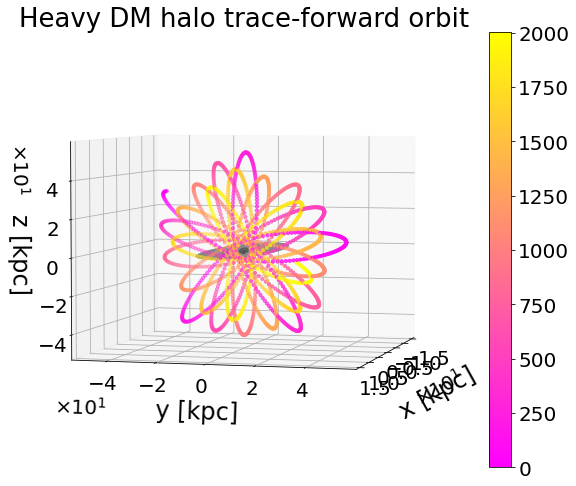

In [19]:
figtfh = plt.figure(figsize=(10, 8))
axtfh = figtfh.add_subplot(projection='3d')


u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x_bulge = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

t = np.linspace(0, 2001, 2001)

sc = axtfh.scatter(heavy_dm_trace_forward_data[0, 1, :], heavy_dm_trace_forward_data[0, 2, :], 
             heavy_dm_trace_forward_data[0, 3, :], c=t, s=10, cmap='spring')


plt.colorbar(sc)
axtfh.set_xlabel('x [kpc]', labelpad=20)
axtfh.set_ylabel('y [kpc]', labelpad=20)
axtfh.set_zlabel('z [kpc]', labelpad=10)
axtfh.set_title('Heavy DM halo trace-forward orbit')
axtfh.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh.yaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh.zaxis.get_major_formatter().set_powerlimits((0, 0))


axtfh.plot_surface(x_bulge, y_bulge, z_bulge, color='grey', alpha=0.5)
axtfh.plot_surface(x_disc, y_disc, z_disc, color='grey', alpha=0.5)


axtfh.view_init(4, 15)

plt.show()

## Heavy DM mass model run: 997814 particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $M_{DM, PETAR} = 11790571849.1532$
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [58]:
%%time
heavy_dm_mod_data, heavy_dm_mod_header, heavy_dm_mod_extra, heavy_dm_mod_hist_data = extract_data(r'Very_heavy_DM_run_data', 
                                                                                          r'Very_heavy_DM_run', 39, 1)

print(heavy_dm_mod_data.shape)
print(heavy_dm_mod_extra.shape)
print(heavy_dm_mod_header.shape)
print(heavy_dm_mod_header[:, -1])

heavy_dm_mod_halfmass_r = heavy_dm_mod_extra[0, :]
print(heavy_dm_mod_halfmass_r)

print(np.max(heavy_dm_mod_halfmass_r))
print(np.min(heavy_dm_mod_halfmass_r))

v_mean_heavy_dm_mod, r_mean_heavy_dm_mod = means_calc(heavy_dm_mod_header)

print(v_mean_heavy_dm_mod.shape)
print(r_mean_heavy_dm_mod.shape)

Number of particles is conserved: True
(997814, 21, 40)
(4, 40)
(8, 40)
[ 9.97814000e+05  4.99200000e+03  7.59504019e+00  3.20926344e+01
 -9.57610947e+00 -1.14667631e+01 -4.82426067e+01  3.93803323e+01]
[ 0.15299975  0.15243015  0.22416054  0.20736321  0.20243308  0.47438444
  0.9863857   2.44690408  1.13925519  3.54969794  8.48998791  1.54088906
  7.84893943  9.48216095  2.56576125 15.7139137   8.19785788  4.65259285
 26.64294946  5.23700993  9.33260616 28.53274307  4.35699573 17.72580171
 21.25987327  6.16443058 30.71675457 13.92436016  9.71274098 40.74517072
 10.95962393 14.41894811 37.12312476 11.03659291 24.06303366 27.57388552
 13.288304   37.38398465 23.01794417 19.31210256]
40.74517072428255
0.15243014936249133
(40,)
(40,)
CPU times: user 11min 21s, sys: 23.9 s, total: 11min 45s
Wall time: 11min 44s


### Pericentre and apocentre analysis

In [59]:
num_shells = 5
heavy_dm_core_mean_pos, heavy_dm_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=heavy_dm_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=heavy_dm_mod_header[2:5, 0], 
                                                       data=heavy_dm_mod_data)

In [60]:
heavy_dm_core_mean_r = np.sqrt(np.sum(heavy_dm_core_mean_pos**2, axis=1))

In [61]:
tsteps = np.arange(0, 40, 1)*128

print(tsteps)

[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456
 3584 3712 3840 3968 4096 4224 4352 4480 4608 4736 4864 4992]


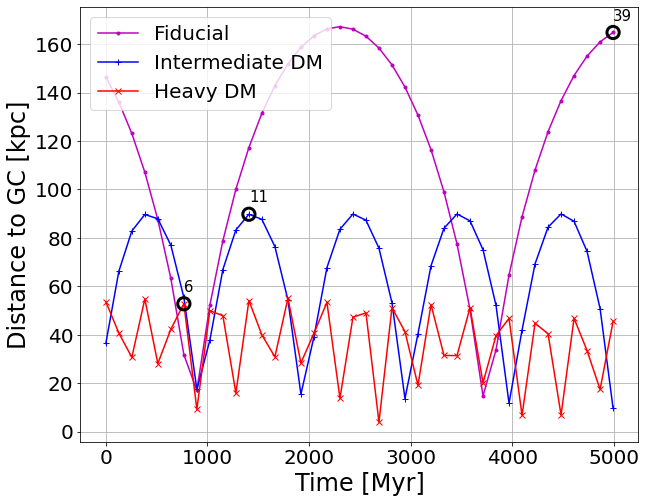

In [62]:
figt3, axt3 = plt.subplots(figsize=(10, 8))

tsteps = np.arange(0, 40, 1)*128

axt3.plot(tsteps, fid_core_mean_r, color='m', marker='.', label='Fiducial')
axt3.scatter(tsteps[-1], fid_core_mean_r[-1], color='k', marker='o', s=150, facecolor='none', linewidths=3,
            zorder=20)
axt3.text(tsteps[-1], fid_core_mean_r[-1]+5,'39', fontsize=15)

axt3.plot(tsteps, intm_dm_core_mean_r, color='b', marker='+', label='Intermediate DM')
axt3.scatter(tsteps[11], intm_dm_core_mean_r[11], color='k', marker='o', s=150, facecolor='none', linewidths=3,
            zorder=20)
axt3.text(tsteps[11], intm_dm_core_mean_r[11]+5,'11', fontsize=15)


axt3.plot(tsteps, heavy_dm_core_mean_r, color='r', marker='x', label='Heavy DM')
axt3.scatter(tsteps[6], heavy_dm_core_mean_r[6], color='k', marker='o', s=150, facecolor='none', linewidths=3,
            zorder=2)
axt3.text(tsteps[6], heavy_dm_core_mean_r[6]+5, '6', fontsize=15)

axt3.set_xlabel('Time [Myr]')
axt3.set_ylabel('Distance to GC [kpc]')

axt3.legend()

plt.savefig('./Plots/Distance_from_GC_and_tsteps_dm.png', facecolor='w', bbox_inches='tight')
plt.show()

### Plotting snapshots

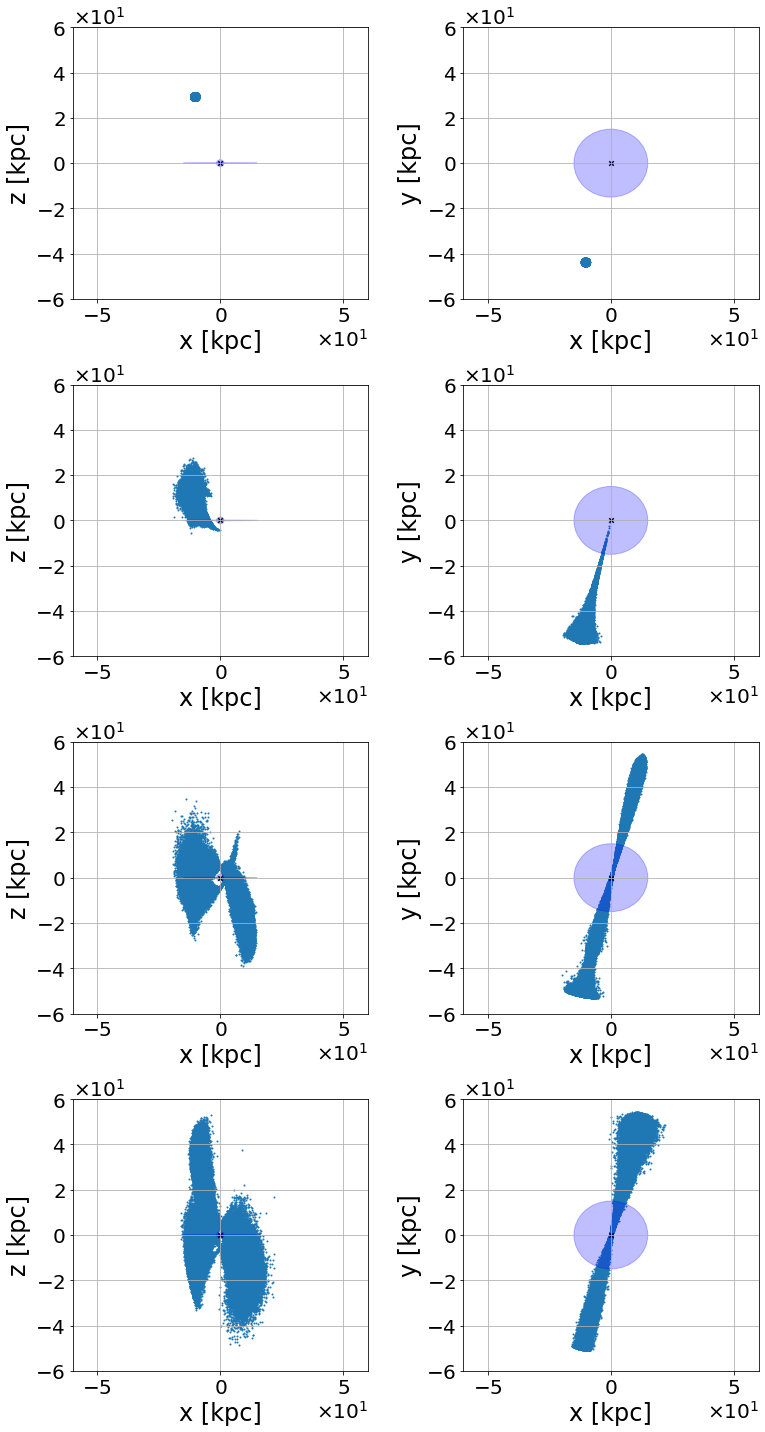

In [63]:
snapshots = [0, 14, 27, -1]
snapshots_plot(heavy_dm_mod_data, snapshots, 0.6e2, 0.6e2, (11, 20), 1, 'Heavy_DM_model', 
               save=False)

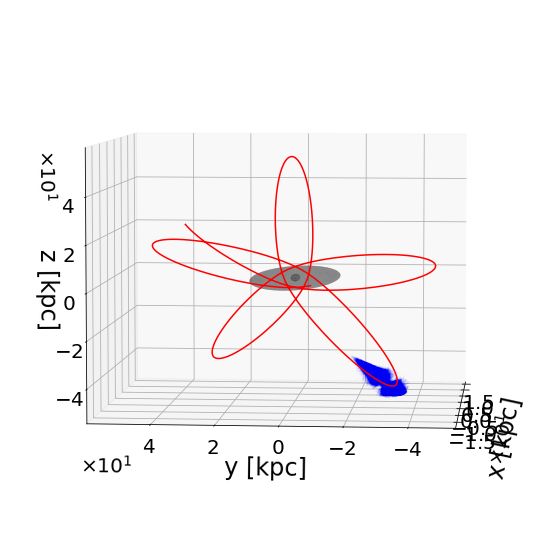

In [75]:
figh1 = plt.figure(figsize=(10, 10))
axh1 = figh1.add_subplot(projection='3d', computed_zorder=False)


u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x_bulge = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))



axh1.scatter(heavy_dm_mod_data[:, 1, 6], heavy_dm_mod_data[:, 2, 6], heavy_dm_mod_data[:, 3, 6], c='b',
        alpha=0.025, s=1, zorder=0)

t1 = 50 #maybe for 30 # 420 for snapshot 15 # 400 for snapshot 14
t2 = 500 #maybe for 30 # 505 for snapshot 15 # 472 for snapshot 14
axh1.plot(heavy_dm_trace_forward_data[0, 1, t1:t2], heavy_dm_trace_forward_data[0, 2, t1:t2], 
             heavy_dm_trace_forward_data[0, 3, t1:t2], color='r', zorder=10)


axh1.set_xlabel('x [kpc]', labelpad=15)
axh1.set_ylabel('y [kpc]', labelpad=15)
axh1.set_zlabel('z [kpc]', labelpad=5)
axh1.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axh1.xaxis.get_major_formatter().set_powerlimits((0, 0))
axh1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axh1.yaxis.get_major_formatter().set_powerlimits((0, 0))
axh1.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axh1.zaxis.get_major_formatter().set_powerlimits((0, 0))

axh1.plot_surface(x_bulge, y_bulge, z_bulge, color='grey', alpha=0.5)
axh1.plot_surface(x_disc, y_disc, z_disc, color='grey', alpha=0.5)


axh1.view_init(5, -175)

plt.show()

### Plotting orbit

tfl = trace forward very heavy (dm)

### Constructing orbit data array for low $v_r$ model

heavy_dm_orbit_position = heavy_dm_trace_forward_header[2:5, 700:1900].T # To get shape (N,x)
heavy_dm_orbit_velocity = heavy_dm_trace_forward_header[5:8, 700:1900].T # To get shape (N,x)
heavy_dm_orbit_times = heavy_dm_trace_forward_header[1, 700:1900].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
heavy_dm_orbit_data = np.concatenate([heavy_dm_orbit_position, heavy_dm_orbit_velocity, heavy_dm_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(heavy_dm_orbit_data)) # Expect shape n,7

### Interpolating orbit

interpolated_heavy_dm_orbit = easy_interpolate(heavy_dm_orbit_data, 2)
print(np.shape(interpolated_heavy_dm_orbit))
#print(interpolated_heavy_dm_orbit[:20, 3:6])

### Making animations

In [29]:
#%%time
#anim_3d(heavy_dm_mod_data, heavy_dm_mod_header, tstep=128, 
#        nsteps=39+1, lims=0.6e2, fsize=(10, 10), 
#        marker_size=1, tx=-0.3e2, ty=0.4e2, tz=0.4e2, 
#        format_type='mp4', fps=3, run='Heavy_dm_model') # lims=2.5e2 and tx=-1.5e2, ty=2.0e2, tz=2.0e2 before

In [116]:
#anim_ComparetoTraceback(heavy_dm_mod_data, heavy_dm_trace_back_data, lims=0.5e2, 
#                        run_file='Heavy_dm_run_and_trace_back', run_title='Heavy DM run compared to trace back',
#                        fsize=(10, 10), fps=1, format_type='mp4')

### Streatching out stream

# Has columns x, y, z, vx, vy, vz
heavy_dm_stream_data = heavy_dm_mod_data[:, 1:7, -1]
heavy_dm_orbital_data = np.delete(interpolated_heavy_dm_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

heavy_dm_aligned1 = stream_alignment_step1(heavy_dm_orbital_data, heavy_dm_stream_data)
print('St1 DONE')
heavy_dm_aligned2 = stream_alignment_step2(heavy_dm_orbital_data, heavy_dm_aligned1)
print('St2 DONE')

heavy_dm_length, heavy_dm_width, heavy_dm_part_dens = stream_shape(heavy_dm_orbital_data, heavy_dm_aligned2)
print('DONE')

heavy_dm_variance = np.sum(heavy_dm_aligned1[:, -2])/len(heavy_dm_aligned1)

print(heavy_dm_variance)

# Comparing streams

### Comparing streams at second apocentre

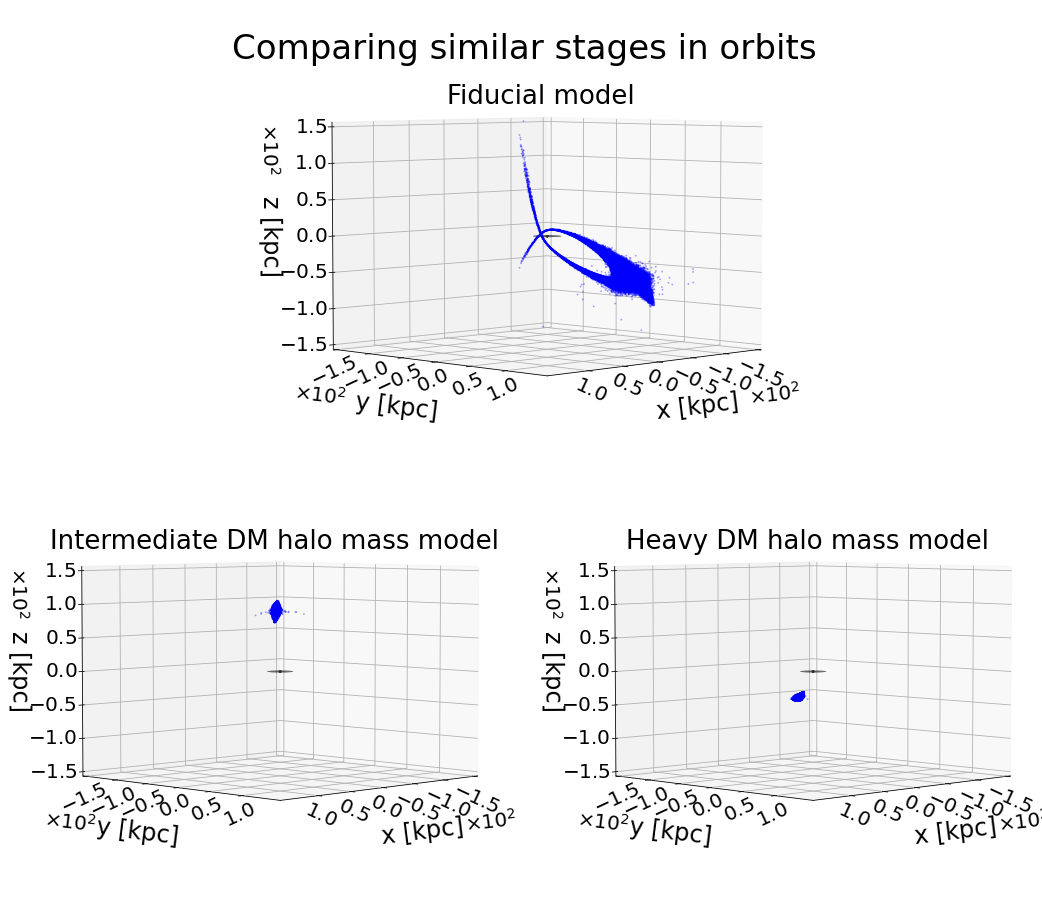

In [205]:
figc1 = plt.figure(figsize=(18,18))

heights = [3, 2]
gs1 = gsp.GridSpec(2, 4, height_ratios=heights)
gs1.update(wspace=0.3, hspace=-0.2)#, right=0.75)#, left=0.5)

axdists = 10
xlabel_pad = 20
ylabel_pad = 20
zlabel_pad = 15
xtick_pad = -5
ytick_pad = -5
ztick_pad = -5
lims = 1.5e2

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

height_angle = 4
side_angle = 45


axc11 = figc1.add_subplot(gs1[0, 1:3], projection='3d')
axc11.scatter(fid_mod_data[:, 1, -1], fid_mod_data[:, 2, -1], fid_mod_data[:, 3, -1], c='b', s=1, alpha=0.25)

axc11.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc11.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc11.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc11.set_title('Fiducial model', y=0.85)

ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
axc11.set_xticks(ticklabels)
axc11.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc11.tick_params(axis='x', pad=xtick_pad)
axc11.set_yticks(ticklabels)
axc11.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc11.tick_params(axis='y', pad=ytick_pad)

zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
axc11.set_zticks(zticklabels)
axc11.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
axc11.tick_params(axis='z', pad=ztick_pad)

axc11.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc11.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc11.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc11.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc11.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc11.zaxis.get_major_formatter().set_powerlimits((0, 0))

axc11.set_xlim(xmin=-lims, xmax=lims)
axc11.set_ylim(ymin=-lims, ymax=lims)
axc11.set_zlim(zmin=-lims, zmax=lims)

x_bulge1 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge1 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge1 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc1 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc1 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc1 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc11.plot_surface(x_bulge1, y_bulge1, z_bulge1, color='grey', alpha=0.5)
axc11.plot_surface(x_disc1, y_disc1, z_disc1, color='grey', alpha=0.5)

axc11.view_init(height_angle, side_angle)
axc11.dist=axdists


axc12 = figc1.add_subplot(gs1[1, :2], projection='3d')
axc12.scatter(intm_dm_mod_data[:, 1, 11], intm_dm_mod_data[:, 2, 11], intm_dm_mod_data[:, 3, 11], c='b', s=1, alpha=0.25)

axc12.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc12.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc12.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc12.set_title('Intermediate DM halo mass model', y=0.85)

ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
axc12.set_xticks(ticklabels)
axc12.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc12.tick_params(axis='x', pad=xtick_pad)
axc12.set_yticks(ticklabels)
axc12.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc12.tick_params(axis='y', pad=ytick_pad)

zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
axc12.set_zticks(zticklabels)
axc12.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
axc12.tick_params(axis='z', pad=ztick_pad)

axc12.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc12.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc12.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc12.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc12.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc12.zaxis.get_major_formatter().set_powerlimits((0, 0))

axc12.set_xlim(xmin=-lims, xmax=lims)
axc12.set_ylim(ymin=-lims, ymax=lims)
axc12.set_zlim(zmin=-lims, zmax=lims)

x_bulge2 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge2 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge2 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc2 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc2 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc2 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc12.plot_surface(x_bulge2, y_bulge2, z_bulge2, color='grey', alpha=0.5)
axc12.plot_surface(x_disc2, y_disc2, z_disc2, color='grey', alpha=0.5)

axc12.view_init(height_angle, side_angle)
axc12.dist=axdists


axc13 = figc1.add_subplot(gs1[1, 2:], projection='3d')
axc13.scatter(heavy_dm_mod_data[:, 1, 6], heavy_dm_mod_data[:, 2, 6], heavy_dm_mod_data[:, 3, 6], c='b', s=1, alpha=0.25)

axc13.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc13.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc13.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc13.set_title('Heavy DM halo mass model', y=0.85)

ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
axc13.set_xticks(ticklabels)
axc13.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc13.tick_params(axis='x', pad=xtick_pad)
axc13.set_yticks(ticklabels)
axc13.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc13.tick_params(axis='y', pad=ytick_pad)

zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
axc13.set_zticks(zticklabels)
axc13.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
axc13.tick_params(axis='z', pad=ztick_pad)

axc13.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc13.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc13.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc13.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc13.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc13.zaxis.get_major_formatter().set_powerlimits((0, 0))


axc13.set_xlim(xmin=-lims, xmax=lims)
axc13.set_ylim(ymin=-lims, ymax=lims)
axc13.set_zlim(zmin=-lims, zmax=lims)

x_bulge3 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge3 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge3 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc3 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc3 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc3 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc13.plot_surface(x_bulge3, y_bulge3, z_bulge3, color='grey', alpha=0.5)
axc13.plot_surface(x_disc3, y_disc3, z_disc3, color='grey', alpha=0.5)

axc13.view_init(height_angle, side_angle)
axc13.dist=axdists

plt.suptitle('Comparing similar stages in orbits', fontsize=34, y=0.79)
#plt.tight_layout()
plt.savefig('./Plots/Comparing_similar_stages_in_orbits_dm.png', facecolor='w', bbox_inches='tight')
plt.show()

### Comparing streams at last snapshot

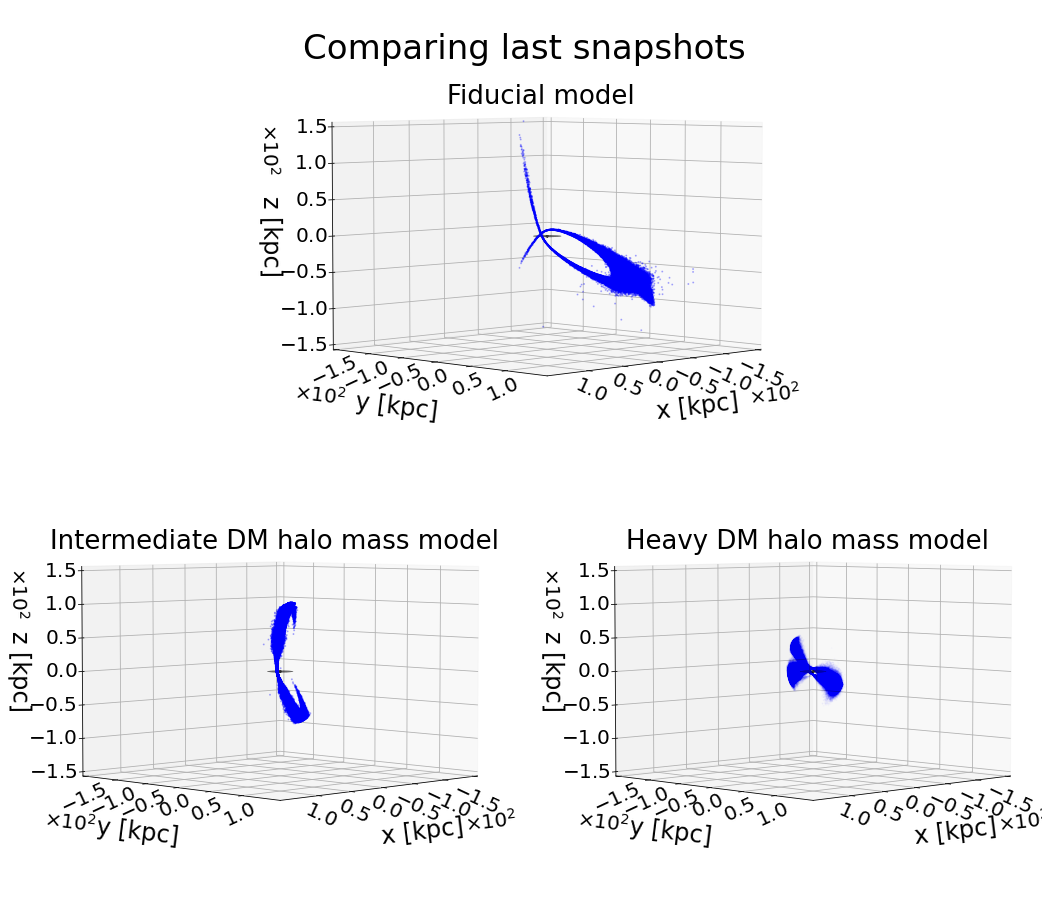

In [209]:
figc2 = plt.figure(figsize=(18,18))

heights = [3, 2]
gs2 = gsp.GridSpec(2, 4, height_ratios=heights)
gs2.update(wspace=0.3, hspace=-0.2)

#axdists = 10
xlabel_pad = 20
ylabel_pad = 20
zlabel_pad = 15
xtick_pad = -5
ytick_pad = -5
ztick_pad = -5
lims = 1.5e2

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

height_angle = 4
side_angle = 45


axc21 = figc2.add_subplot(gs1[0, 1:3], projection='3d')
axc21.scatter(fid_mod_data[:, 1, -1], fid_mod_data[:, 2, -1], fid_mod_data[:, 3, -1], 
              c='b', s=1, alpha=0.25)

axc21.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc21.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc21.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc21.set_title('Fiducial model', y=0.85)

ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
axc21.set_xticks(ticklabels)
axc21.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc21.tick_params(axis='x', pad=xtick_pad)
axc21.set_yticks(ticklabels)
axc21.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc21.tick_params(axis='y', pad=ytick_pad)

zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
axc21.set_zticks(zticklabels)
axc21.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
axc21.tick_params(axis='z', pad=ztick_pad)

axc21.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc21.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc21.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc21.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc21.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc21.zaxis.get_major_formatter().set_powerlimits((0, 0))


axc21.set_xlim(xmin=-lims, xmax=lims)
axc21.set_ylim(ymin=-lims, ymax=lims)
axc21.set_zlim(zmin=-lims, zmax=lims)

x_bulge1 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge1 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge1 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc1 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc1 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc1 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc21.plot_surface(x_bulge1, y_bulge1, z_bulge1, color='grey', alpha=0.5)
axc21.plot_surface(x_disc1, y_disc1, z_disc1, color='grey', alpha=0.5)

axc21.view_init(height_angle, side_angle)



axc22 = figc2.add_subplot(gs1[1, :2], projection='3d')
axc22.scatter(intm_dm_mod_data[:, 1, -1], intm_dm_mod_data[:, 2, -1], intm_dm_mod_data[:, 3, -1], 
              c='b', s=1, alpha=0.25)

axc22.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc22.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc22.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc22.set_title('Intermediate DM halo mass model', y=0.85)

ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
axc22.set_xticks(ticklabels)
axc22.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc22.tick_params(axis='x', pad=xtick_pad)
axc22.set_yticks(ticklabels)
axc22.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc22.tick_params(axis='y', pad=ytick_pad)

zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
axc22.set_zticks(zticklabels)
axc22.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
axc22.tick_params(axis='z', pad=ztick_pad)

axc22.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc22.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc22.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22.zaxis.get_major_formatter().set_powerlimits((0, 0))

axc22.set_xlim(xmin=-lims, xmax=lims)
axc22.set_ylim(ymin=-lims, ymax=lims)
axc22.set_zlim(zmin=-lims, zmax=lims)

x_bulge2 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge2 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge2 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc2 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc2 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc2 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc22.plot_surface(x_bulge2, y_bulge2, z_bulge2, color='grey', alpha=0.5)
axc22.plot_surface(x_disc2, y_disc2, z_disc2, color='grey', alpha=0.5)

axc22.view_init(height_angle, side_angle)



axc23 = figc2.add_subplot(gs1[1, 2:], projection='3d')
axc23.scatter(heavy_dm_mod_data[:, 1, -1], heavy_dm_mod_data[:, 2, -1], heavy_dm_mod_data[:, 3, -1], 
              c='b', s=1, alpha=0.01) #heavy_dm_mod_data[:, 0, -1], cmap='Wistia'

axc23.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc23.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc23.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc23.set_title('Heavy DM halo mass model', y=0.85)

ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
axc23.set_xticks(ticklabels)
axc23.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc23.tick_params(axis='x', pad=xtick_pad)
axc23.set_yticks(ticklabels)
axc23.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
axc23.tick_params(axis='y', pad=ytick_pad)

zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
axc23.set_zticks(zticklabels)
axc23.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
axc23.tick_params(axis='z', pad=ztick_pad)

axc23.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc23.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc23.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc23.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc23.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc23.zaxis.get_major_formatter().set_powerlimits((0, 0))

axc23.set_xlim(xmin=-lims, xmax=lims)
axc23.set_ylim(ymin=-lims, ymax=lims)
axc23.set_zlim(zmin=-lims, zmax=lims)

x_bulge3 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge3 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge3 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc3 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc3 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc3 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc23.plot_surface(x_bulge3, y_bulge3, z_bulge3, color='grey', alpha=0.5)
axc23.plot_surface(x_disc3, y_disc3, z_disc3, color='grey', alpha=0.5)

axc23.view_init(height_angle, side_angle)


plt.suptitle('Comparing last snapshots', fontsize=34, y=0.79)
#plt.tight_layout()
plt.savefig('./Plots/Comparing_last_snapshots_dm.png', facecolor='w', bbox_inches='tight')
plt.show()

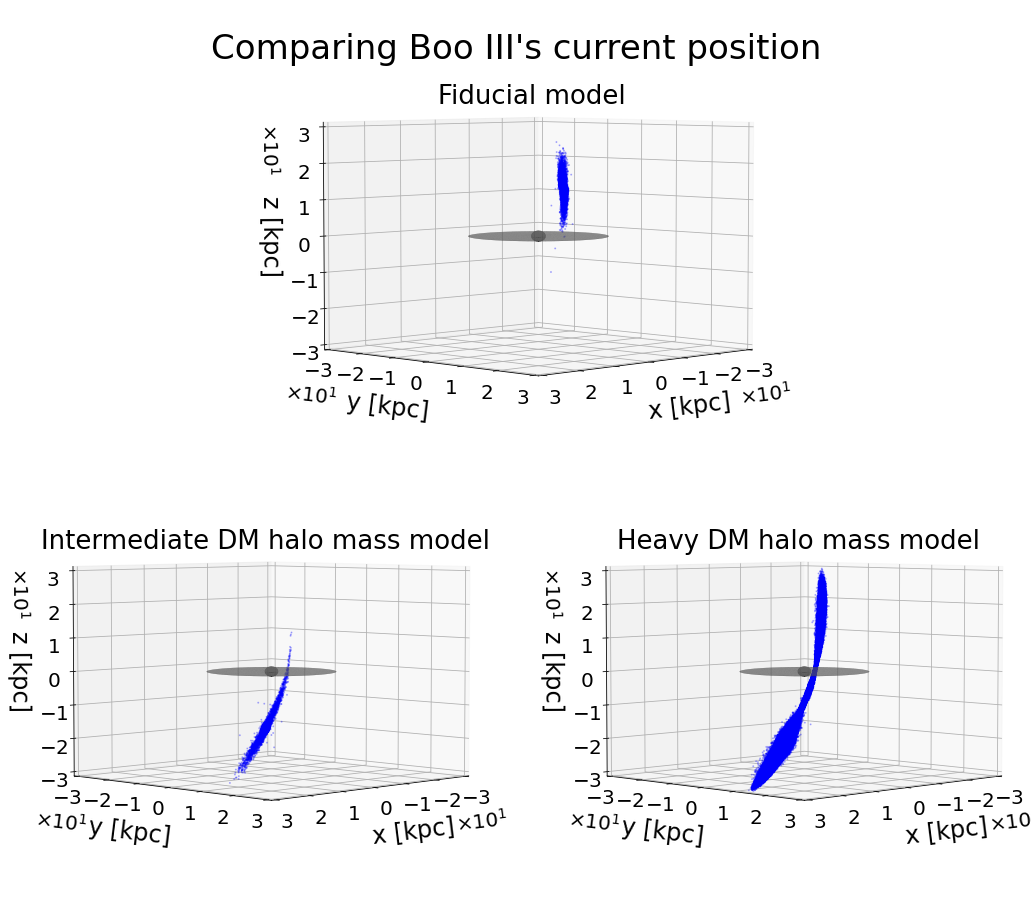

In [212]:
figc3 = plt.figure(figsize=(18,18))

heights = [3, 2]
gs3 = gsp.GridSpec(2, 4, height_ratios=heights)
gs3.update(wspace=0.5, hspace=-0.3)

#axdists = 10
xlabel_pad = 20
ylabel_pad = 20
zlabel_pad = 10
xtick_pad = -5
ytick_pad = -5
ztick_pad = -5
lims = 1.5e2

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

height_angle = 4
side_angle = 45


axc31 = figc3.add_subplot(gs1[0, 1:3], projection='3d')
axc31.scatter(fid_mod_data[:, 1, 7], fid_mod_data[:, 2, 7], fid_mod_data[:, 3, 7], 
              c='b', s=1, alpha=0.25)

axc31.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc31.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc31.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc31.set_title('Fiducial model', y=0.85)

#ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
#axc31.set_xticks(ticklabels)
#axc31.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
#axc31.tick_params(axis='x', pad=xtick_pad)
#axc31.set_yticks(ticklabels)
#axc31.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
#axc31.tick_params(axis='y', pad=ytick_pad)

#zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
#axc31.set_zticks(zticklabels)
#axc31.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
#axc31.tick_params(axis='z', pad=ztick_pad)

axc31.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc31.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc31.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc31.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc31.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc31.zaxis.get_major_formatter().set_powerlimits((0, 0))

lims = 0.3e2
axc31.set_xlim(xmin=-lims, xmax=lims)
axc31.set_ylim(ymin=-lims, ymax=lims)
axc31.set_zlim(zmin=-lims, zmax=lims)

x_bulge1 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge1 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge1 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc1 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc1 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc1 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc31.plot_surface(x_bulge1, y_bulge1, z_bulge1, color='grey', alpha=0.5)
axc31.plot_surface(x_disc1, y_disc1, z_disc1, color='grey', alpha=0.5)

axc31.view_init(height_angle, side_angle)



axc32 = figc3.add_subplot(gs1[1, :2], projection='3d')
axc32.scatter(intm_dm_mod_data[:, 1, 7], intm_dm_mod_data[:, 2, 7], intm_dm_mod_data[:, 3, 7], 
              c='b', s=1, alpha=0.25)

axc32.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc32.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc32.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc32.set_title('Intermediate DM halo mass model', y=0.85)

#ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
#axc32.set_xticks(ticklabels)
#axc32.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
#axc32.tick_params(axis='x', pad=xtick_pad)
#axc32.set_yticks(ticklabels)
#axc32.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
#axc32.tick_params(axis='y', pad=ytick_pad)

#zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
#axc32.set_zticks(zticklabels)
#axc32.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
#axc32.tick_params(axis='z', pad=ztick_pad)

axc32.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc32.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc32.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32.zaxis.get_major_formatter().set_powerlimits((0, 0))

axc32.set_xlim(xmin=-lims, xmax=lims)
axc32.set_ylim(ymin=-lims, ymax=lims)
axc32.set_zlim(zmin=-lims, zmax=lims)

x_bulge2 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge2 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge2 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc2 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc2 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc2 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc32.plot_surface(x_bulge2, y_bulge2, z_bulge2, color='grey', alpha=0.5)
axc32.plot_surface(x_disc2, y_disc2, z_disc2, color='grey', alpha=0.5)

axc32.view_init(height_angle, side_angle)



axc33 = figc3.add_subplot(gs1[1, 2:], projection='3d')
axc33.scatter(heavy_dm_mod_data[:, 1, 7], heavy_dm_mod_data[:, 2, 7], heavy_dm_mod_data[:, 3, 7], 
              c='b', s=1, alpha=0.25) #heavy_dm_mod_data[:, 0, -1], cmap='Wistia'

axc33.set_xlabel('x [kpc]', labelpad=xlabel_pad)
axc33.set_ylabel('y [kpc]', labelpad=ylabel_pad)
axc33.set_zlabel('z [kpc]', labelpad=zlabel_pad)
axc33.set_title('Heavy DM halo mass model', y=0.85)

#ticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0])*1e2
#axc33.set_xticks(ticklabels)
#axc33.set_xticklabels(ticklabels, rotation=-25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
#axc33.tick_params(axis='x', pad=xtick_pad)
#axc33.set_yticks(ticklabels)
#axc33.set_yticklabels(ticklabels, rotation=25, horizontalalignment='center')#, horizontalalignment='left', verticalalignment='baseline')
#axc33.tick_params(axis='y', pad=ytick_pad)

#zticklabels = np.array([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])*1e2
#axc33.set_zticks(zticklabels)
#axc33.set_zticklabels(zticklabels, horizontalalignment='right', verticalalignment='center')
#axc33.tick_params(axis='z', pad=ztick_pad)

axc33.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc33.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc33.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc33.yaxis.get_major_formatter().set_powerlimits((0, 0))
axc33.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc33.zaxis.get_major_formatter().set_powerlimits((0, 0))

axc33.set_xlim(xmin=-lims, xmax=lims)
axc33.set_ylim(ymin=-lims, ymax=lims)
axc33.set_zlim(zmin=-lims, zmax=lims)

x_bulge3 = 1.500 * np.outer(np.cos(u), np.sin(v))
y_bulge3 = 1.500 * np.outer(np.sin(u), np.sin(v))
z_bulge3 = 1.500 * np.outer(np.ones(np.size(u)), np.cos(v))

x_disc3 = 14.490 * np.outer(np.cos(u), np.sin(v))
y_disc3 = 14.490 * np.outer(np.sin(u), np.sin(v))
z_disc3 = 0.300 * np.outer(np.ones(np.size(u)), np.cos(v))

axc33.plot_surface(x_bulge3, y_bulge3, z_bulge3, color='grey', alpha=0.5)
axc33.plot_surface(x_disc3, y_disc3, z_disc3, color='grey', alpha=0.5)

axc33.view_init(height_angle, side_angle)


plt.suptitle("Comparing Boo III's current position" , fontsize=34, y=0.79)
#plt.tight_layout()
plt.savefig('./Plots/Comparing_BooIIIs_position_dm.png', facecolor='w', bbox_inches='tight')
plt.show()

### Variance (I think)

print(fid_variance, intm_dm_variance, heavy_dm_variance)

### Length

figc1, axc1 = plt.subplots(figsize=(12, 8))

plt.minorticks_on()

x_vals = np.array([1, 2, 3])
y_vals = np.array([fid_length, intm_dm_length, heavy_dm_length])

labels = ["Fiducial", "Intermediate DM", "Heavy DM"]


axc1.scatter(x_vals, y_vals, s=30, c='b', zorder=10)

axc1.set_title('Stream lengths')
axc1.set_ylabel('Length [kpc]')

axc1.set_xticks(x_vals, labels=labels)
axc1.set_xticklabels(labels, minor=False)


axc1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc1.yaxis.get_major_formatter().set_powerlimits((0, 0))

plt.grid(which='both', zorder=-10)


plt.savefig('./Plots/Length_comparisons_dm.png', facecolor='w')
plt.show()

### Width

figc2, axc2 = plt.subplots(figsize=(15, 7))

axc2.scatter(fid_orbital_data[:, -1], fid_width, c='b', s=10, alpha=0.25, label='Fiducial')
axc2.scatter(intm_dm_orbital_data[:, -1], intm_dm_width, c='darkviolet', s=10, alpha=0.25, label='Intermediate DM')
axc2.scatter(heavy_dm_orbital_data[:, -1], heavy_dm_width, c='deeppink', s=10, alpha=0.25, label='Heavy DM')


axc2.set_title('Width along stream')
axc2.set_xlabel('Distance in stream [kpc]')
axc2.set_ylabel('Width [kpc]')

axc2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc2.yaxis.get_major_formatter().set_powerlimits((0, 0))

axc2.set_ylim(ymin=0, ymax=0.4e2)


lgnd = axc2.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)

plt.savefig('./Plots/Width_along_stream_comparison_dm.png', facecolor='w')
plt.show()

nbins=25

diff_fid_i = binned_relative_difference(intm_dm_width, intm_dm_aligned2, fid_width, fid_aligned2, fid_orbital_data, nbins)

diff_fid_h = binned_relative_difference(heavy_dm_width, heavy_dm_aligned2, fid_width, fid_aligned2, fid_orbital_data, nbins)



diff_i_h = binned_relative_difference(heavy_dm_width, heavy_dm_aligned2, intm_dm_width, intm_dm_aligned2, intm_dm_orbital_data, nbins)

figc22, axc22 = plt.subplots(2, 1, figsize=(15, 12))


# Scatter plot with errorbars
# ------------------------------------------------------------------------------------
axc22[0].scatter(diff_fid_i[:, 0], diff_fid_i[:, 1], c='darkgreen', label='Fiducial-Intermediate DM', s=10)
axc22[0].scatter(diff_fid_h[:, 0], diff_fid_h[:, 1], c='lime', label='Fiducial-Heavy DM', s=10)


axc22[0].errorbar(diff_fid_i[:, 0], diff_fid_i[:, 1], yerr=diff_fid_i[:, 2], ecolor='darkgreen', capsize=1, 
                 linestyle='')
axc22[0].errorbar(diff_fid_h[:, 0], diff_fid_h[:, 1], yerr=diff_fid_h[:, 2], ecolor='lime', capsize=1, 
                 linestyle='')



axc22[0].set_ylim(ymin=-5, ymax=5)
axc22[0].set_ylabel('Relative difference')
axc22[0].set_xlabel('Distance in stream [kpc]')

axc22[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22[0].xaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc22[0].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)



axc22[1].scatter(diff_i_h[:, 0], diff_i_h[:, 1], c='b', label=r'Intermediate DM - Heavy DM', s=10)

axc22[1].errorbar(diff_i_h[:, 0], diff_i_h[:, 1], yerr=diff_i_h[:, 2], ecolor='b', capsize=1, linestyle='')


axc22[1].set_ylim(ymin=-5, ymax=5)
axc22[1].set_ylabel('Relative difference')
axc22[1].set_xlabel('Distance in stream [kpc]')

axc22[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22[1].xaxis.get_major_formatter().set_powerlimits((0, 0))

lgnd = axc22[1].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)

figc22.suptitle('Relative difference in stream width', fontsize=28)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
#plt.savefig('./Plots/Relative_differences_width_dm.png', facecolor='w')
plt.show()

### Particle density

figc3, axc3 = plt.subplots(figsize=(15, 7))

axc3.scatter(fid_orbital_data[:, -1], fid_part_dens, c='b', s=10, alpha=0.25, label='Fiducial')
axc3.scatter(intm_dm_orbital_data[:, -1], intm_dm_part_dens, c='darkviolet', s=10, alpha=0.25, label='Intermediate DM')
axc3.scatter(heavy_dm_orbital_data[:, -1], heavy_dm_part_dens, c='m', s=10, alpha=0.25, label='Heavy DM')


axc3.set_title('Particle distribution along stream')
axc3.set_xlabel('Distance in stream [kpc]')
axc3.set_ylabel('Particle count')

axc3.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc3.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc3.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc3.yaxis.get_major_formatter().set_powerlimits((0, 0))

axc3.set_ylim(ymin=0, ymax=0.5e3)


lgnd = axc3.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)


#plt.savefig('./Plots/Particle_density_along_stream_comparison_dm.png', facecolor='w')
plt.show()

nbins = 25

diff_part_dens_fid_i = binned_relative_difference(intm_dm_part_dens, intm_dm_aligned2, fid_part_dens, fid_aligned2, 
                                                  fid_orbital_data, nbins)

diff_part_dens_fid_h = binned_relative_difference(heavy_dm_part_dens, heavy_dm_aligned2, fid_part_dens, fid_aligned2, 
                                                  fid_orbital_data, nbins)



diff_part_dens_i_h = binned_relative_difference(heavy_dm_part_dens, heavy_dm_aligned2, intm_dm_part_dens, intm_dm_aligned2, 
                                                  intm_dm_orbital_data, nbins)

figc32, axc32 = plt.subplots(2, 1, figsize=(15, 12))

axc32[0].scatter(diff_part_dens_fid_i[:, 0], diff_part_dens_fid_i[:, 1], c='darkgreen', 
                 label='Fiducial-Intermediate DM', s=10)
axc32[0].scatter(diff_part_dens_fid_h[:, 0], diff_part_dens_fid_h[:, 1], c='lime', 
                 label='Fiducial-Heavy DM', s=10)

axc32[0].errorbar(diff_part_dens_fid_i[:, 0], diff_part_dens_fid_i[:, 1], yerr=diff_part_dens_fid_i[:, 2], 
                  ecolor='darkgreen', capsize=1, linestyle='')
axc32[0].errorbar(diff_part_dens_fid_h[:, 0], diff_part_dens_fid_h[:, 1], yerr=diff_part_dens_fid_h[:, 2], 
                  ecolor='lime', capsize=1, linestyle='')



axc32[0].set_ylim(ymin=-5, ymax=5)
axc32[0].set_ylabel('Relative difference')
axc32[0].set_xlabel('Distance in stream [kpc]')

axc32[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32[0].xaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc32[0].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)



axc32[1].scatter(diff_part_dens_i_h[:, 0], diff_part_dens_i_h[:, 1], c='b', label='Intermediate DM-Heavy DM', s=10)


axc32[1].errorbar(diff_part_dens_i_h[:, 0], diff_part_dens_i_h[:, 1], yerr=diff_part_dens_i_h[:, 2], 
                  ecolor='b', capsize=1, linestyle='')

axc32[1].set_ylim(ymin=-2, ymax=2)
axc32[1].set_ylabel('Relative difference')
axc32[1].set_xlabel('Distance in stream [kpc]')

axc32[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32[1].xaxis.get_major_formatter().set_powerlimits((0, 0))

lgnd = axc32[1].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)

figc32.suptitle('Relative difference in particle distribution', fontsize=28)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('./Plots/Relative_differences_particle_density_dm.png', facecolor='w')
plt.show()